<a href="https://colab.research.google.com/github/mu06905/GPU-Accelerated-Programming-in-Cuda-2023/blob/main/Week3/Assignment1Q2(Parellel%20Sum%20Reduction%231).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-fxwvptj8
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-fxwvptj8
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=669a376e81f0edac6655211939e7bf49c3884fd0dc60ef1f27fa53e34dfa7d2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pwzl32y1/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


reference:
https://github.com/CoffeeBeforeArch/cuda_programming/blob/master/03_sum_reduction/bank_conflicts/sumReduction.cu

The parallel reduction logic is taken from the above mentioned source.
Details:
Each block contains 250 threads and number of blocks are launched depending on the length of input array using formula: N/250
Inside each kernel function, data from global memory is copied into shared memory which is of size 250. thread sync function is used which waits for each thread to write data in shared memory and helps to prevent race condition. 
On each iteration of the for loop, the number of threads are halved and the stride is multiplied by two. On first iteration, 125 threads will be launched which will add every alternate element of the array in current position. Index would be of sequence 0,2,4,.. 124. Hence after first iteration, we'll get an array in shared memory whose alternating indices (0,2,4 ..124) will be the sum of every pair of elements from the global array. 

After the for loop is executed, the first element of every array in shared memory would contain the sum of 250 elements of the global array. We launch the kernel again to sum over these arrays


In [80]:
%%cu
#include <stdio.h>
#include "cuda_runtime.h"

//shared memory size
#define SHMEM_SIZE 1000

__global__ void sumReduction(int *v, int *v_r) {
  // Allocate shared memory
  __shared__ int partial_sum[SHMEM_SIZE];

  // Calculate thread ID
  int tid = blockIdx.x * blockDim.x + threadIdx.x;

  // Load elements into shared memory
  
    partial_sum[threadIdx.x] = v[tid];
  
  __syncthreads();

  // Increase the stride of the access until we exceed the CTA dimensions
  for (int s = 1; s < blockDim.x; s *= 2) {
      

        // Change the indexing to be sequential threads
        int index = 2 * s * threadIdx.x;

        // Each thread does work unless the index goes off the block
        if (index < blockDim.x) {
        partial_sum[index] += partial_sum[index + s];
        }
      
    __syncthreads();
  }

  // Let the thread 0 for this block write its result to main memory
  // Result is indexed by this block
  if (threadIdx.x == 0) {
    v_r[blockIdx.x] = partial_sum[0];
  }
}

int main() {
  // Vector size
  const int N = 10000;
  int* initial_host_data = 0;
  int* final_host_data = 0;


  int size = N * sizeof(int);
  initial_host_data = (int*)malloc(N*sizeof(int));
  final_host_data = (int*)malloc(N*sizeof(int));
  for(int i = 0; i<N;i++){
      initial_host_data[i] = i+1;
      final_host_data[i] = 0;
  }
  int start = clock() ;
  int sum = 0;
  for(int i = 0;i<N;i++){
      sum+=initial_host_data[i];
  }
  int time_d = clock() - start;
  printf("sum on host %d\n", sum);
  printf("time on cpu is: %d ms\n", time_d);
  int *initial_device_data, *final_device_data;
  cudaMalloc((void**)&initial_device_data, size);
  cudaMalloc((void**)&final_device_data, size);

  // Copy to device hv to dv
  cudaMemcpy(initial_device_data, initial_host_data, size, cudaMemcpyHostToDevice);
  cudaMemcpy(final_device_data, final_host_data, size, cudaMemcpyHostToDevice);

  // TB Size
  const int TB_SIZE = 1000;

  // Grid Size (No padding)
  int GRID_SIZE = N / TB_SIZE;

  cudaEvent_t start_d, stop_d;
	cudaEventCreate(&start_d);
	cudaEventCreate(&stop_d);
  // Call kernels
  cudaEventRecord(start_d);
  sumReduction<<<GRID_SIZE, TB_SIZE>>>(initial_device_data, final_device_data);

  sumReduction<<<1, TB_SIZE>>>(final_device_data, final_device_data);
  cudaEventRecord(stop_d);
  cudaEventSynchronize(stop_d);
	float dt = 0;
  cudaEventElapsedTime(&dt, start_d, stop_d);
  printf("Total time on GPU: %f ms\n", dt);
  // Copy to host;
  cudaMemcpy(final_host_data, final_device_data, size, cudaMemcpyDeviceToHost);

 printf("result = %d", final_host_data[0]);

  return 0;
}

sum on host 50005000
time on cpu is: 22 ms
Total time on GPU: 0.047136 ms
result = 50005000


In [75]:
import matplotlib.pyplot as plt

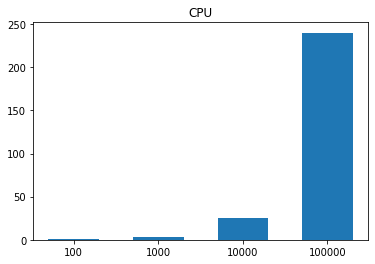

In [81]:
left_coordinates=[1,2,3,4]
heights = [1,3,25,240]
bar_labels=['100','1000','10000','100000']
plt.title("CPU")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()

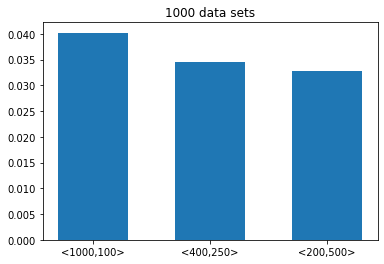

In [77]:
left_coordinates=[1,2,3]
heights = [0.040224,0.034464,0.032736]
bar_labels=['<1000,100>','<400,250>','<200,500>']
plt.title("1000 data sets")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()

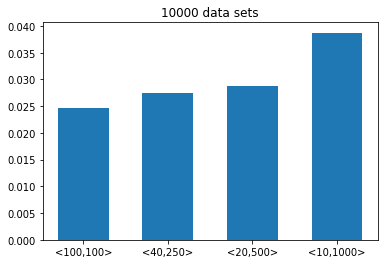

In [65]:
left_coordinates=[1,2,3,4]
heights=[0.024576,0.027424,0.028864,0.038752]
bar_labels=['<100,100>','<40,250>','<20,500>','<10,1000>']
plt.title("10000 data sets")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()


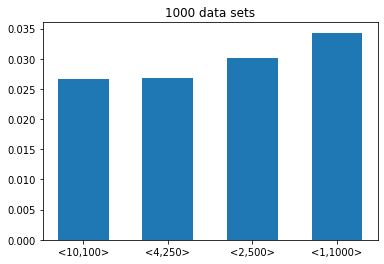

In [82]:
left_coordinates=[1,2,3,4]
heights=[0.026656, 0.026848, 0.030144,0.034304]
bar_labels=['<10,100>','<4,250>','<2,500>','<1,1000>']
plt.title("1000 data sets")
plt.bar(left_coordinates,heights,tick_label=bar_labels,width=0.6)
plt.show()